#  <center>Segmentation des tumeurs cérébrales avec U-net</center>


# Importation des donnees :

dataset source : https://www.sciencedirect.com/science/article/pii/S095741742302849X#tbl3

cette dataset est composé de 4237 images IRM de tumeurs cérébrales, chacune accompagnée d'un masque manuel généré par des experts, permettant une identification précise des contours des tumeurs. Ce dataset sert de référence pour entraîner le modèle de segmentation, en se concentrant sur quatre types de tumeurs :(glioma, meningioma, pituitary, and no tumor).

**description :**

Image :
* 0 (No Tumor, 1595 images),
* 1 (Glioma, 649 images),
* 2 (Meningioma, 999 images),
* 3 (Pituitary, 994 images),
    
Mask :
* 0 (No Tumor, 1595 images),
* 1 (Glioma, 650 images),
* 2 (Meningioma, 1000 images),
* 3 (Pituitary, 994 images),

# importation des donnees

In [1]:
#importation des packages
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
import tensorflow.keras.backend as K

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Chemin d'accès aux données
data_path = "Brain Tumor Segmentation Dataset"

# Classes des tumeurs
classes = ['no_tumor', 'glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

# Initialisation des listes pour stocker les images et les masques
images = []
masks = []
labels = []
# Dimensions souhaitées pour les images et les masques
target_size = (128, 128) 

# Chargement des images et des masques
for class_name in classes:
    image_folder = os.path.join(data_path, 'image', str(classes.index(class_name)))
    mask_folder = os.path.join(data_path, 'mask', str(classes.index(class_name)))
    
    # Vérification si les dossiers existent
    if os.path.exists(image_folder) and os.path.exists(mask_folder):
        # Chargement des images
        for image_name in tqdm(os.listdir(image_folder), desc=class_name):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):  # Vérification du format
                image_path = os.path.join(image_folder, image_name)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                image = cv2.resize(image, target_size) 
                image = image / 255.0
                
                # Vérification du nom du masque correspondant
                mask_name = image_name.replace('.jpg', '_m.jpg').replace('.png', '_m.png')
                mask_path = os.path.join(mask_folder, mask_name)

                # Chargement du masque seulement s'il existe
                if os.path.exists(mask_path):
                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, target_size) 
                    mask = mask / 255.0
                    
                    # Ajout des images et masques aux listes
                    images.append(image)
                    masks.append(mask)
                    labels.append(classes.index(class_name))
                
                else:
                    print(f"Masque manquant pour l'image: {image_name}")

# Conversion des listes en tableaux NumPy
images = np.array(images).reshape(-1, 128, 128, 1)
masks = np.array(masks).reshape(-1, 128, 128, 1)
labels = np.array(labels)

# Affichage des dimensions des ensembles de données
print(f"Nombre d'images : {len(images)}, Nombre de masques : {len(masks)}, nombre de labels: {len(labels)}")

no_tumor:   0%|          | 0/1595 [00:00<?, ?it/s]

glioma_tumor:   0%|          | 0/649 [00:00<?, ?it/s]

meningioma_tumor:   0%|          | 0/999 [00:00<?, ?it/s]

pituitary_tumor:   0%|          | 0/994 [00:00<?, ?it/s]

Nombre d'images : 4237, Nombre de masques : 4237, nombre de labels: 4237


# visualisation des donnees

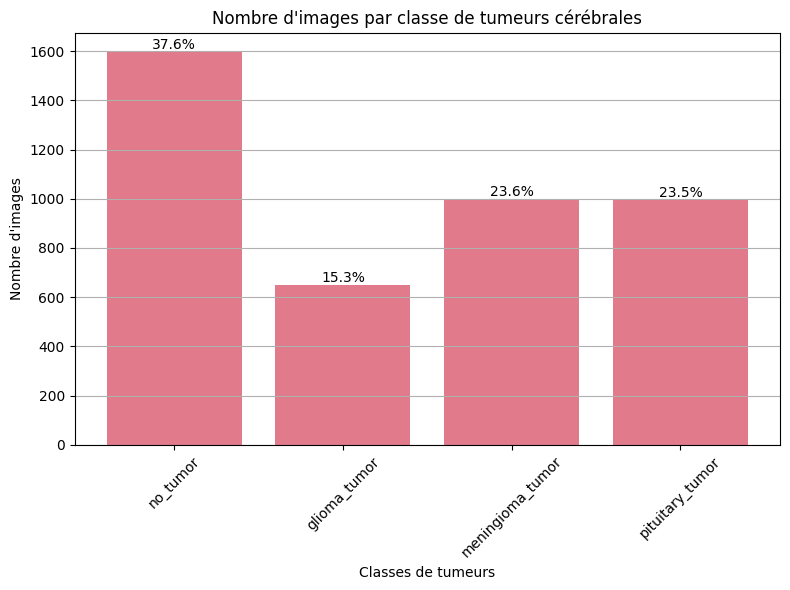

In [3]:
# Compter le nombre d'images par classe
unique, counts = np.unique(labels, return_counts=True)
class_counts = dict(zip(classes, counts))

# Calculer le total d'images et les pourcentages
total_images = sum(class_counts.values())
percentages = [(count / total_images) * 100 for count in class_counts.values()]

# Créer le diagramme à barres
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color='#E17A8A')

# Ajouter les pourcentages au-dessus des barres
for bar, percentage in zip(bars, percentages):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{percentage:.1f}%', ha='center', va='bottom')

plt.xlabel('Classes de tumeurs')
plt.ylabel('Nombre d\'images')
plt.title('Nombre d\'images par classe de tumeurs cérébrales')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Afficher le plot
plt.tight_layout()
plt.show()

> Les classes présentent une distribution déséquilibrée, avec la classe "no tumor" représentant une proportion significative (37.6%), tandis que les autres types de tumeurs ont des représentations plus faibles. Ce déséquilibre pourrait affecter la performance du modèle U-Net

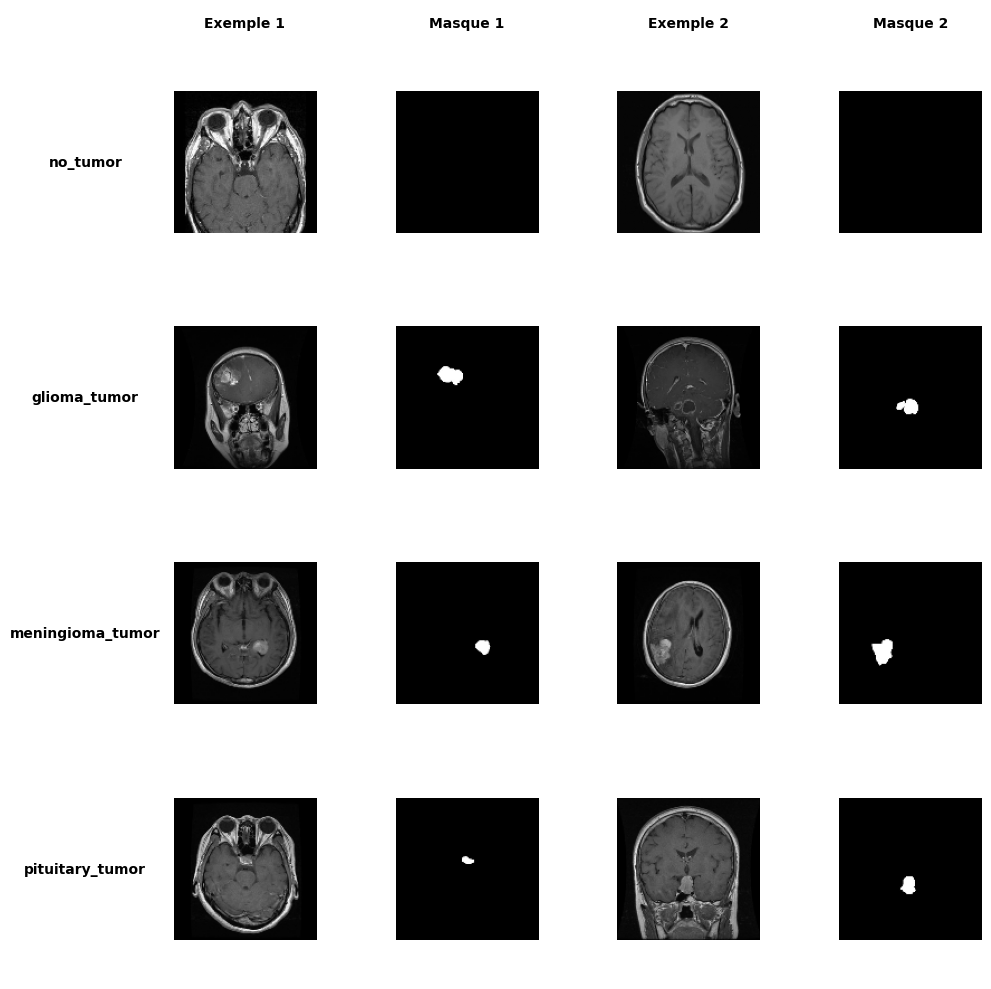

In [4]:
# Initialiser la figure avec une grille pour 4 classes
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(10, 10), 
                         gridspec_kw={'width_ratios': [0.5, 4, 4, 4 ,4], 'height_ratios': [0.5, 4, 4, 4, 4]})

# Titre des colonnes
axs[0, 0].text(0.5, 0.5, "", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 0].axis('off')  # Enlever les axes

axs[0, 1].text(0.5, 0.5, "Exemple 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 1].axis('off')  # Enlever les axes

axs[0, 2].text(0.5, 0.5, "Masque 1", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 2].axis('off')  # Enlever les axes

axs[0, 3].text(0.5, 0.5, "Exemple 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 3].axis('off')  # Enlever les axes

axs[0, 4].text(0.5, 0.5, "Masque 2", fontsize=10, ha='center', va='center', fontweight='bold')
axs[0, 4].axis('off')  # Enlever les axes

for i, class_name in enumerate(classes):
    # Trouver un index d'image et de masque pour chaque classe
    class_index = classes.index(class_name)
    
    # Récupérer un exemple d'image et de masque pour chaque classe
    example_index1 = np.where(labels == class_index)[0][0]  # Prendre le premier exemple de chaque classe
    example_index2 = np.where(labels == class_index)[0][2]  # Prendre le deuxieme exemple 
    image1 = images[example_index1]
    mask1 = masks[example_index1]
    
    image2 = images[example_index2]
    mask2 = masks[example_index2]
    
    # Afficher l'image
    axs[i + 1, 1].imshow(image1, cmap='gray')
    axs[i + 1, 1].axis('off')  # Enlever les axes

    # Afficher le masque
    axs[i + 1, 2].imshow(mask1, cmap='gray')
    axs[i + 1, 2].axis('off')  # Enlever les axes
    
    # Afficher l'image
    axs[i + 1, 3].imshow(image2, cmap='gray')
    axs[i + 1, 3].axis('off')  # Enlever les axes

    # Afficher le masque
    axs[i + 1, 4].imshow(mask2, cmap='gray')
    axs[i + 1, 4].axis('off')  # Enlever les axes

    # Centrer le texte dans la colonne de la classe
    axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
    axs[i + 1, 0].axis('off')  # Enlever les axes

plt.tight_layout()
plt.show()


# Préparation des donnees

In [5]:
# Diviser les données en ensembles d'entraînement (75%) et de validation (25%)
images_train, images_val, masks_train, masks_val, labels_train, labels_val = train_test_split(
    images, masks, labels, test_size=0.3, random_state=42, stratify=labels, shuffle=True
)

# Affichage des dimensions des ensembles
print(f"Ensemble d'entraînement - Images: {images_train.shape}, Masques: {masks_train.shape}, Labels: {labels_train.shape}")
print(f"Ensemble de validation - Images: {images_val.shape}, Masques: {masks_val.shape}, Labels: {labels_val.shape}")

Ensemble d'entraînement - Images: (2965, 128, 128, 1), Masques: (2965, 128, 128, 1), Labels: (2965,)
Ensemble de validation - Images: (1272, 128, 128, 1), Masques: (1272, 128, 128, 1), Labels: (1272,)


In [6]:
# Fonction pour créer un générateur qui applique la même augmentation aux images et aux masques
def train_generator(images, masks, batch_size, seed=42):
    image_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    mask_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Générateurs pour les images et les masques
    image_generator = image_datagen.flow(images, batch_size=batch_size, seed=seed)
    mask_generator = mask_datagen.flow(masks, batch_size=batch_size, seed=seed)
    
    while True:
        # Génère un batch d'images et de masques
        img_batch = next(image_generator)  # Utiliser `next(image_generator)`
        mask_batch = next(mask_generator)  # Utiliser `next(mask_generator)`
        
        yield img_batch, mask_batch


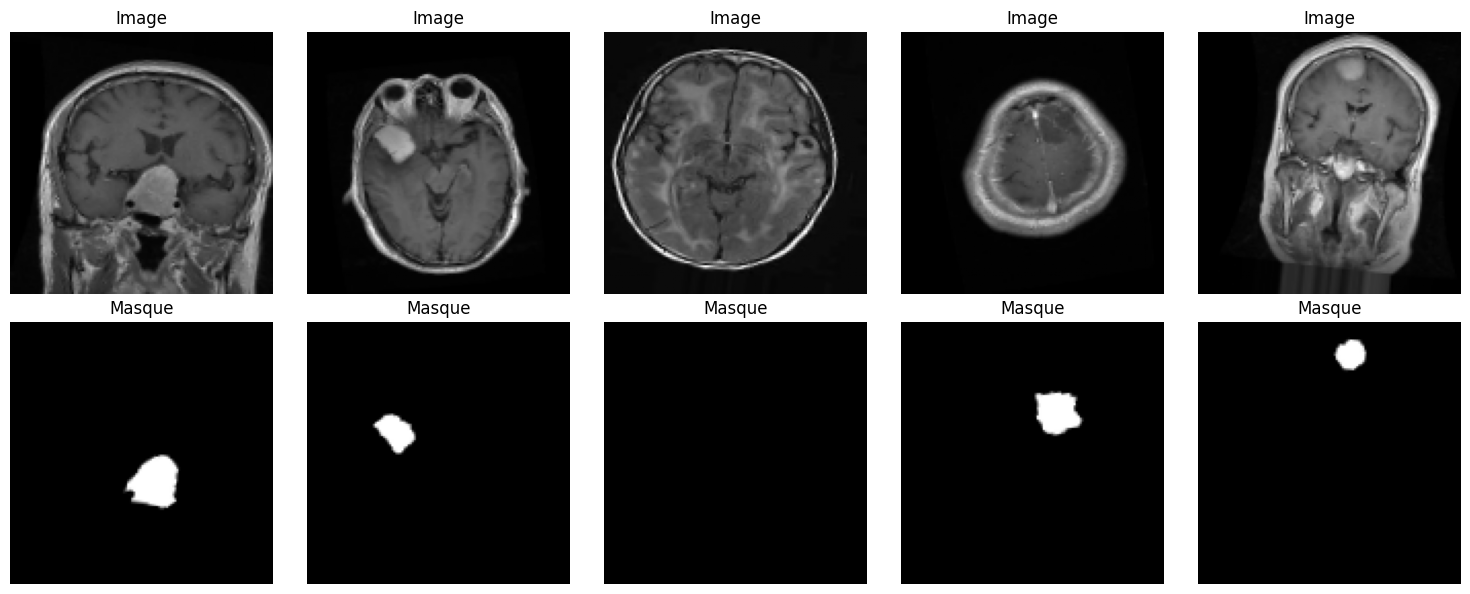

In [7]:
# Fonction pour afficher des images et leurs masques correspondants
def plot_images(images, masks, num_images=5):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        # Afficher l'image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].reshape(128, 128), cmap='gray')  # Ajustez la forme si nécessaire
        plt.axis('off')
        plt.title('Image')

        # Afficher le masque correspondant
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(masks[i].reshape(128, 128), cmap='gray')  # Ajustez la forme si nécessaire
        plt.axis('off')
        plt.title('Masque')
    
    plt.tight_layout()
    plt.show()

# Tester le générateur d'augmentation en prenant quelques images
images_batch, masks_batch = next(train_generator(images_train, masks_train, batch_size=5))


# Afficher les images et les masques
plot_images(images_batch, masks_batch, num_images=5)

# modélisation : U-NET

Les métriques **Dice Coefficient (DICE), Dice Loss et Intersection over Union (IoU)** sont couramment utilisées pour évaluer les performances des modèles de segmentation d'images, en particulier dans les tâches de segmentation médicale :

<div style='text-align: center'>
    <img src="https://www.researchgate.net/publication/354660434/figure/fig4/AS:1069085387395072@1631901227555/The-visualization-of-Dice-and-IoU-The-left-image-presents-the-Dice-coefficient-the.png" width="250">
    </div>

> **1. Dice Coefficient (DICE) :**
> Le Dice Coefficient, également connu sous le nom de indice de Dice-Sørensen, est une métrique qui mesure la similarité entre deux ensembles. Dans le contexte de la segmentation d'images, il est utilisé pour comparer les masques prédits par le modèle avec les masques de référence (les masques "vérités terrain" ou ground truth).
>
> * La valeur du Dice Coefficient varie entre 0 et 1 :
>  * 1 signifie une correspondance parfaite entre la prédiction et la vérité terrain.
>  * 0 signifie aucune correspondance.

> **2. Dice Loss :**
> Le Dice Loss est une fonction de perte dérivée du Dice Coefficient. Il est utilisé pour l'entraînement des modèles de segmentation afin de minimiser la différence entre les masques prédits et les masques réels.
>
> * un Dice Loss faible correspond à un Dice Coefficient élevé, ce qui signifie que la prédiction est très proche du masque réel.

> **3. Intersection over Union (IoU) :**
> L'Intersection over Union (IoU), également appelée Jaccard Index, est une autre métrique populaire en segmentation d'images. Elle mesure le degré de chevauchement entre le masque prédit et le masque réel.
>
> * Comme le Dice Coefficient, la valeur de l'IoU varie entre 0 et 1 :
>   * 1 signifie un chevauchement parfait entre le masque prédit et le masque réel.
>   * 0 signifie aucun chevauchement.



In [8]:
# Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Dice Loss (à utiliser comme fonction de perte)
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def iou(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    total = K.sum(y_true_f) + K.sum(y_pred_f)
    union = total - intersection
    return (intersection + smooth) / (union + smooth)


In [9]:
# Définir le modèle U-Net
def unet_model(input_shape):
    inputs = layers.Input(input_shape)

    # Contratction Path
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Expansive Path
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Sortie avec une seule couche, pour la segmentation binaire
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Créer le modèle
    model = models.Model(inputs=[inputs], outputs=[outputs])
    
    return model


# Définir la forme d'entrée (hauteur, largeur, canaux)
input_shape = (128, 128, 1) 
model = unet_model(input_shape)
model.summary()

# Compiler le modèle
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy',dice_coefficient,iou])


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ dropout_1[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ dropout_2[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ dropout_3[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 512) │          0 │ conv2d_7[0][0]  

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Définir les callbacks
model_checkpoint = ModelCheckpoint('best_unetmodel.keras',  # Nom du fichier pour sauvegarder le meilleur modèle
                                   monitor='val_dice_coefficient',  # Suivre la valeur de validation du Dice Coefficient
                                   save_best_only=True,  # Sauvegarder uniquement le meilleur modèle
                                   mode='max',  # Chercher la valeur maximale
                                   verbose=1  # Afficher un message lors de la sauvegarde
                                  )

early_stopping = EarlyStopping(monitor='val_dice_coefficient',
                               patience=10,  # Arrêter après 15 époques sans amélioration
                               mode='max',  # Chercher la valeur maximale
                               verbose=1  # Afficher un message lors de l'arrêt
                              )

# Utiliser le générateur d'augmentation pour l'entraînement
batch_size = 32
train_gen = train_generator(images_train, masks_train, batch_size=batch_size)

# Entraînement du modèle avec le générateur
history = model.fit(
    train_gen,
    steps_per_epoch=len(images_train) // batch_size,
    epochs=100,
    validation_data=(images_val, masks_val),
    callbacks=[model_checkpoint, early_stopping]
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9205 - dice_coefficient: 0.0124 - iou: 0.0063 - loss: 0.3651
Epoch 1: val_dice_coefficient improved from -inf to 0.05421, saving model to best_unetmodel.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 698s 7s/step - accuracy: 0.9211 - dice_coefficient: 0.0125 - iou: 0.0063 - loss: 0.3631 - val_accuracy: 0.9870 - val_dice_coefficient: 0.0542 - val_iou: 0.0279 - val_loss: 0.0645
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9847 - dice_coefficient: 0.0398 - iou: 0.0204 - loss: 0.0487
Epoch 2: val_dice_coefficient improved from 0.05421 to 0.05627, saving model to best_unetmodel.keras
92/92 ━━━━━━━━━━━━━━━━━━━━ 673s 7s/step - accuracy: 0.9847 - dice_coefficient: 0.0398 - iou: 0.0204 - loss: 0.0487 - val_accuracy: 0.9870 - val_dice_coefficient: 0.0563 - val_iou: 0.0290 - val_loss: 0.0689
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9857 - dice_coefficient: 0.0387 - iou: 0.0198 - loss: 0.0454
Epoch 3: val_d

# Evaluation

In [ ]:
# Évaluation du modèle sur l'ensemble d'entrainement
train_loss, train_accuracy, train_dice_coef, train_iou_coef = model.evaluate(images_train, masks_train, verbose=1)
print(f'Training Loss: {train_loss:.4f}')
print(f'Training Accuracy: {train_accuracy:.4f}')
print(f'Training Dice Coefficient: {train_dice_coef:.4f}')
print(f'Training IoU Coefficient: {train_iou_coef:.4f}')

In [ ]:
# Évaluation du modèle sur l'ensemble de validation
val_loss, val_accuracy, val_dice_coef, val_iou_coef = model.evaluate(images_val, masks_val, verbose=1)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Dice Coefficient: {val_dice_coef:.4f}')
print(f'Validation IoU Coefficient: {val_iou_coef:.4f}')

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Tracer la courbe de Loss
axs[0, 0].plot(history.history['loss'], label='Training Loss')
axs[0, 0].plot(history.history['val_loss'], label='Validation Loss')
axs[0, 0].set_title('Loss over Epochs')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].legend()

# Tracer la courbe d'Accuracy
axs[0, 1].plot(history.history['accuracy'], label='Training Accuracy')
axs[0, 1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[0, 1].set_title('Accuracy over Epochs')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 0].set_ylim(0, 1)
axs[0, 1].legend()

# Tracer la courbe du Dice Coefficient
axs[1, 0].plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
axs[1, 0].plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
axs[1, 0].set_title('Dice Coefficient over Epochs')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Dice Coefficient')
axs[1, 0].legend()

# Tracer la courbe de l'IoU
axs[1, 1].plot(history.history['iou'], label='Training IoU')
axs[1, 1].plot(history.history['val_iou'], label='Validation IoU')
axs[1, 1].set_title('IoU over Epochs')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('IoU')
axs[1, 1].legend()

# Ajuster les espaces entre les sous-graphiques
plt.tight_layout()
plt.show()


In [ ]:
# Prédictions sur un ensemble de validation
predictions = model.predict(images_val)  # Remplacez images_test par votre ensemble de test
predictions = (predictions > 0.5).astype(np.uint8)  # Binariser les prédictions


In [ ]:
# Visualiser quelques résultats
n = 5  # Nombre d'exemples à afficher
plt.figure(figsize=(15, 15))

for i in range(n):
    # Image d'entrée
    plt.subplot(n, 3, i * 3 + 1)
    plt.imshow(images_val[i+1].reshape(128, 128), cmap='gray')
    plt.title('Image d\'entrée',fontsize=10)
    plt.axis('off')

    # Masque réel
    plt.subplot(n, 3, i * 3 + 2)
    plt.imshow(masks_val[i+1].reshape(128, 128), cmap='gray')
    plt.title('Masque réel',fontsize=10)
    plt.axis('off')

    # Masque prédit
    plt.subplot(n, 3, i * 3 + 3)
    plt.imshow(predictions[i+1].reshape(128, 128), cmap='gray')
    plt.title('Masque prédit',fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


# Prédiction

Ces prédictions ont été effectuées sur un autre ensemble de données de classification de tumeurs cérébrales ["brain-tumor-classification-mri"](http://https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri) pour évaluer la robustesse du modèle de segmentation U-Net, permettant d'analyser des images IRM provenant d'un contexte différent.

In [ ]:
# Chemin vers le dataset de test
test_dir = '/kaggle/input/brain-tumor-classification-mri/Training'

# Charger deux images de chaque classe pour tester
test_images = []
test_labels = []

for class_name in classes:
    class_folder = os.path.join(test_dir, class_name)
    
    # Récupérer les noms des images de test
    image_names = os.listdir(class_folder)
    
    # S'assurer qu'il y a au moins 2 images
    if len(image_names) >= 2:
        for image_name in image_names[:2]:  # Prendre les deux premières images de chaque classe
            image_path = os.path.join(class_folder, image_name)
            
            # Charger et prétraiter l'image
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, target_size)
            image = image / 255.0
            image = np.expand_dims(image, axis=-1)  # Ajouter la dimension pour les canaux
            
            test_images.append(image)
            test_labels.append(class_name)

# Convertir en tableau NumPy
test_images = np.array(test_images)

# Faire des prédictions sur ces nouvelles images
test_predictions = model.predict(test_images)
test_predictions = (test_predictions > 0.5).astype(np.uint8)



# Initialiser la figure avec une grille pour chaque classe
fig, axs = plt.subplots(len(classes) + 1, 5, figsize=(15, 10), 
                         gridspec_kw={'width_ratios': [0.5, 4, 4, 4, 4], 'height_ratios': [0.5] + [4]*len(classes)})

# Titre des colonnes
titles = ["Classe", "Image 1", "Masque Prédit 1", "Image 2", "Masque Prédit 2"]
for j in range(5):
    axs[0, j].text(0.5, 0.5, titles[j], fontsize=10, ha='center', va='center', fontweight='bold')
    axs[0, j].axis('off')

# Affichage des images et de leurs prédictions
for i, class_name in enumerate(classes):
    class_indices = [j for j, label in enumerate(test_labels) if label == class_name]
    
    if len(class_indices) >= 2:  # Vérifier s'il y a au moins 2 indices pour la classe
        example_index1 = class_indices[0]
        example_index2 = class_indices[1]

        # Afficher le nom de la classe
        axs[i + 1, 0].text(0.5, 0.5, class_name, fontsize=10, ha='center', va='center', fontweight='bold')
        axs[i + 1, 0].axis('off')  # Enlever les axes
        
        # Afficher la première image
        axs[i + 1, 1].imshow(test_images[example_index1].squeeze(), cmap='gray')
        axs[i + 1, 1].axis('off')  # Enlever les axes

        # Afficher le masque prédit pour la première image
        axs[i + 1, 2].imshow(test_predictions[example_index1], cmap='gray')
        axs[i + 1, 2].axis('off')  # Enlever les axes

        # Afficher la seconde image
        axs[i + 1, 3].imshow(test_images[example_index2].squeeze(), cmap='gray')
        axs[i + 1, 3].axis('off')  # Enlever les axes

        # Afficher le masque prédit pour la seconde image
        axs[i + 1, 4].imshow(test_predictions[example_index2], cmap='gray')
        axs[i + 1, 4].axis('off')  # Enlever les axes

plt.tight_layout()
plt.show()
